The aim of this notebook is to perform a quick test for an update of the model or a new optimization procedure.
To test a model update, each cell of this notebook must run with correct results.
To test a new optimization procedure, a new dedicated cell must be created on the same model as the previous ones.

As this pipeline consist in only one instance solved by each procedure once, it statisticaly has no meaning. For a statisticaly meaningful test pipeline, please run the Test pipeline notebook (heavily time consuming). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale

Error: IPOPT shared library failed to import


Generate the theoritical organoïd

In [2]:
organo = generate_ring(10, 110, 150)
Nf= organo.Nf
geom.update_all(organo)
normalize_scale(organo, geom)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + 1/(20*(organo.settings['R_out']-organo.settings['R_in']))


# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  alpha*organo.face_df.area, 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)

symetric_tensions = set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)
sin_mul = 1+(np.sin(np.linspace(0, 2*np.pi, organo.Nf, endpoint=False)))**2
organo.face_df.prefered_area *= np.random.normal(1.0, 0.05, organo.Nf)
organo.edge_df.line_tension = prepare_tensions(organo, symetric_tensions)
organo.edge_df.loc[:Nf-1, 'line_tension'] *= sin_mul

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

new_tensions = organo.edge_df.line_tension

organo.edge_df.loc[:,'line_tension'] = new_tensions
                                                          
res = Solver.find_energy_min(organo, geom, model)                                                       

Reseting datasets values with new specs


Creating a printing function

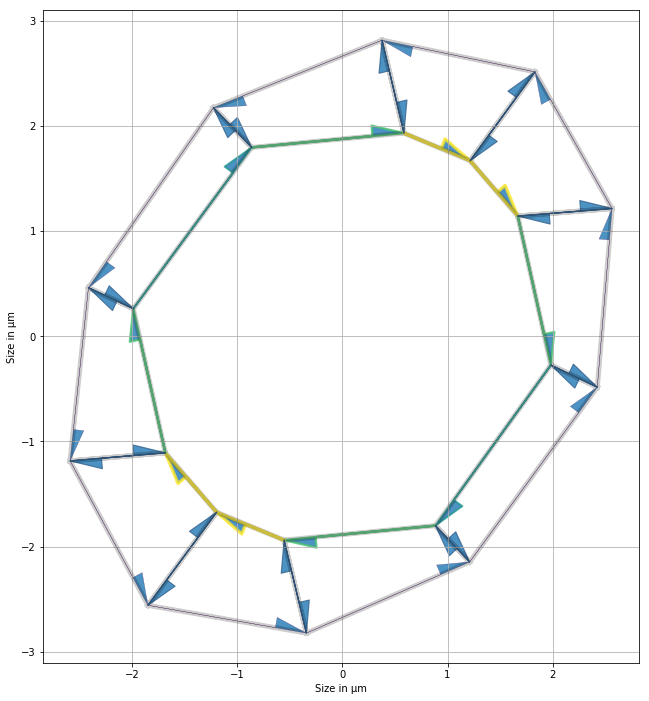

In [3]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()

    edge_color = np.array([1/max(exp_organo.edge_df.line_tension)*l for l in exp_organo.edge_df.line_tension])

    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap #[0, 0, 0, 1]
    #draw_specs['edge']['color'] = [0, 0, 0, 0.2]

    draw_specs['edge']['width'] = 0.25+3*np.array([1/max(exp_organo.edge_df.line_tension)*l for l in exp_organo.edge_df.line_tension])
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)

    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')
    
print_tensions(organo, organo)

Define the optimization parameters

In [4]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-15,'ftol': 1e-8, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-15,'ftol': 1e-8, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'PSQP'}

reg_weight = 1e-3
theta = 0.02

# Robustness to extraction errors

At first we test robustness to extraction errors. This is done by create an organoïd whit perturbated (x,y) coordinates. 
Then we run the optimization procedure, which gives us an experimental organoïd, and measure how far the result is from the theoritical organoïd.

In [10]:
noisy = organo.copy()
initial_guess = organo.edge_df.line_tension[:3*organo.Nf].copy()
noisy.vert_df.loc[:, ('x','y')] *= np.random.normal(1.0,theta,(noisy.Nv,2))
geom.update_all(noisy)

## LM distance minimization
This minimization procedure uses Levenberg-Marquardt (lm) procedure from scipy.least_squares to find the set of linear tensions that minimize the euclidian distance from the theoritical organoid to the experimental organoid. 
It can be implemented with or without a regulzarization module that regularize the linear tensions of the apical or basal edges. 
It can be implemented with or without the lumen volume as an optimization parameter.
A particularity of lm algorithm is that it needs at least as many residuals as optimization parameters. 
Also, it does not support bounds. 

As residuals, we will consider the vertex to vertex distance from the experimental organoïd to the theoritical organoïd (2/3 Nf residuals) , the regularization module edge to edge value if needed (2/3 Nf residuals), and bound penalties of the form  $$ M*(min(0,l)+min(0,UB-l)) \forall l \in L$$ Where $M$ is a big negative number, $UB_l$ is the upper bound for parameter $l$, $L$ is the set of optimization parameters.

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

`ftol` termination condition is satisfied.
Function evaluations 1250, initial cost 4.1130e-02, final cost 2.5571e-02, first-order optimality 6.42e+00.
Solving time: 1632.1108410000002
Tension error: [0.06272603 0.18664011 0.11495549 0.01608263 0.09187526 0.04036124
 0.05091684 0.05722469 0.09551349 0.01782354        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf 0.08187469 0.27210784 0.23796663 0.34269087
 0.26713658 0.06359276 0.33391335 0.17220305 0.16011733 0.21944242]


/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


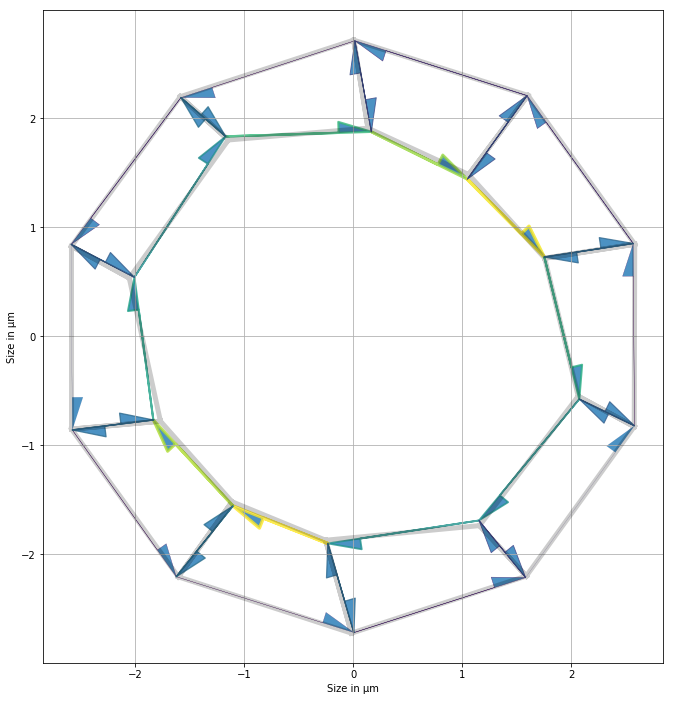

In [6]:
start = time.clock()
res = adjust_tensions(noisy, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, **lm_opt)
noisy_lm_nr_nl = noisy.copy()
noisy_lm_nr_nl.edge_df.line_tension = prepare_tensions(noisy_lm_nr_nl,res.x)
Solver.find_energy_min(noisy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_lm_nr_nl, organo)

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

`ftol` termination condition is satisfied.
Function evaluations 70, initial cost 6.0189e+01, final cost 5.2961e+01, first-order optimality 3.86e-01.
Solving time: 153.18451700000014
Tension error: [0.00301206 0.00526771 0.00132257 0.00224093 0.00156924 0.00778911
 0.00471433 0.00492535 0.00116755 0.00767119        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf 0.03926008 0.04903797 0.04833943 0.01164808
 0.03726571 0.0285358  0.01207158 0.01570612 0.00540159 0.00250962]


/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


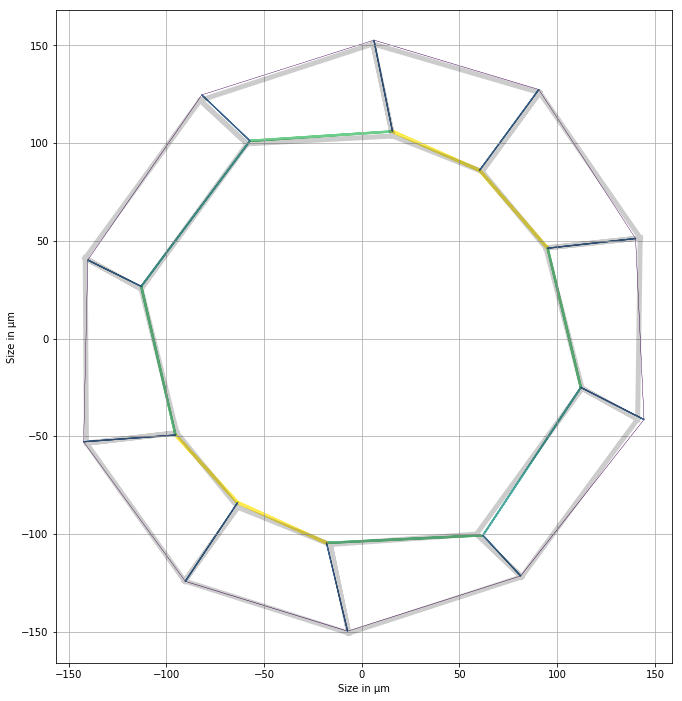

In [56]:
start = time.clock()
res = adjust_tensions(noisy, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **lm_opt)
noisy_lm_r_nl = noisy.copy()
noisy_lm_r_nl.edge_df.line_tension = prepare_tensions(noisy_lm_r_nl,res.x)
Solver.find_energy_min(noisy_lm_r_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_lm_r_nl, organo)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

`ftol` termination condition is satisfied.
Function evaluations 132, initial cost 5.2453e+01, final cost 5.0845e+01, first-order optimality 7.82e-01.
Solving time: 259.991301
Tension error: [0.00114501 0.00176204 0.00080752 0.00100456 0.00030804 0.00245363
 0.00015301 0.0001429  0.00029526 0.00063505        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf 0.00894756 0.00930215 0.00969028 0.00282998
 0.00740942 0.0051893  0.00245194 0.00323152 0.00051473 0.00101117]


/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


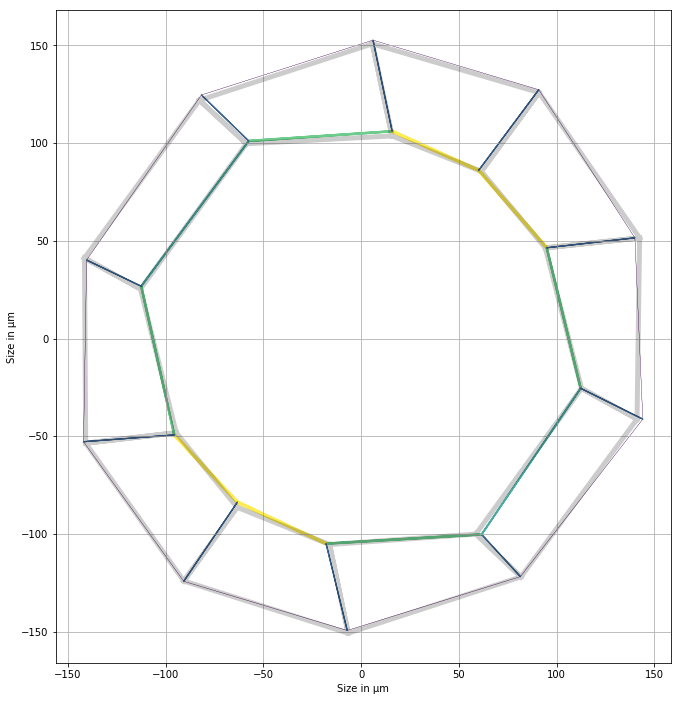

In [61]:
start = time.clock()
res = adjust_tensions(noisy, np.concatenate((initial_guess, [organo.settings['lumen_volume']])), 
                      {'dic':{}, 'weight':0}, energy_opt, **lm_opt)
noisy_lm_nr_l = noisy.copy()
noisy_lm_nr_l.edge_df.line_tension = prepare_tensions(noisy_lm_nr_l,res.x)
Solver.find_energy_min(noisy_lm_nr_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_lm_nr_l, organo)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

`ftol` termination condition is satisfied.
Function evaluations 196, initial cost 5.9951e+01, final cost 5.6253e+01, first-order optimality 6.51e-01.
Solving time: 336.6010839999999
Tension error: [0.00040658 0.00207728 0.00057137 0.00068699 0.00207135 0.00290174
 0.00300027 0.00809153 0.00432877 0.01049969        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf 0.00996588 0.01473421 0.03100361 0.01319489
 0.01555826 0.00315574 0.00497027 0.01303368 0.01897993 0.01699817]


/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


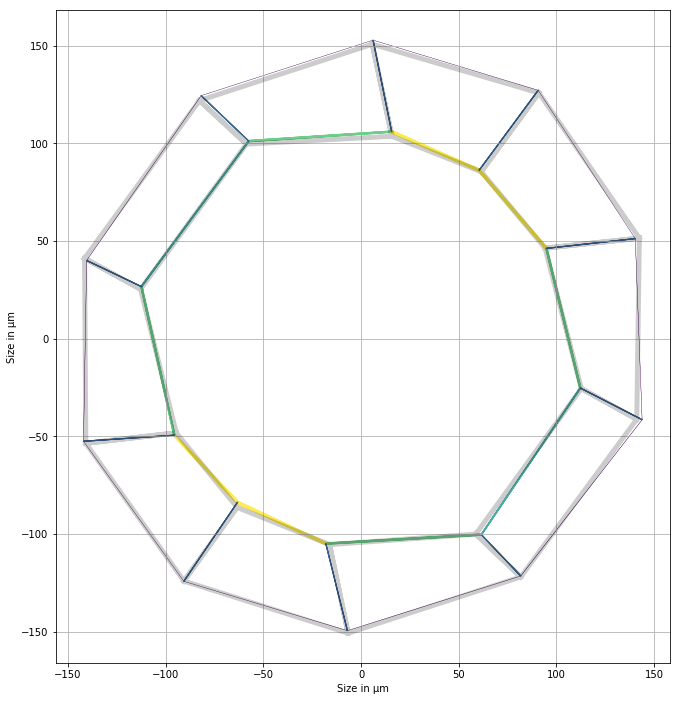

In [63]:
start = time.clock()
res = adjust_tensions(noisy, np.concatenate((initial_guess, [organo.settings['lumen_volume']])),
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **lm_opt)

noisy_lm_r_l = noisy.copy()
noisy_lm_r_l.edge_df.line_tension = prepare_tensions(noisy_lm_r_l,res.x)
Solver.find_energy_min(noisy_lm_r_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_lm_r_l, organo)

## TRF distance minimization
This minimization procedure uses Trust Region Function (trf) procedure from scipy.least_squares to find the set of linear tensions that minimize the euclidian distance from the theoritical organoid to the experimental organoid. 
It can be implemented with or without a regulzarization module that regularize the linear tensions of the apical or basal edges. 
It can be implemented with or without the lumen volume as an optimization parameter.

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0560e-01                                    7.91e+03    
       1              5         2.8599e-01      1.96e-02       1.95e-03       3.16e+03    
       2              6         2.7792e-01      8.06e-03       3.90e-03       7.97e+03    
       3              8         2.7120e-01      6.72e-03       9.76e-04       3.69e+03    
       4              9         2.6878e-01      2.42e-03       9.76e-04       2.51e+03    
       5             10         2.6697e-01      1.81e-03       9.76e-04       3.73e+03    
       6             11         2.6628e-01      6.93e-04       9.76e-04       3.07e+03    
       7             12         2.6508e-01      1.20e-03       2.44e-04       2.78e+03    
       8             13         2.6351e-01      1.57e-03       4.88e-04       3.05e+03    
       9             14         2.6217e-01      1.34e-03       9.76e-04       2.75e+03    

/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


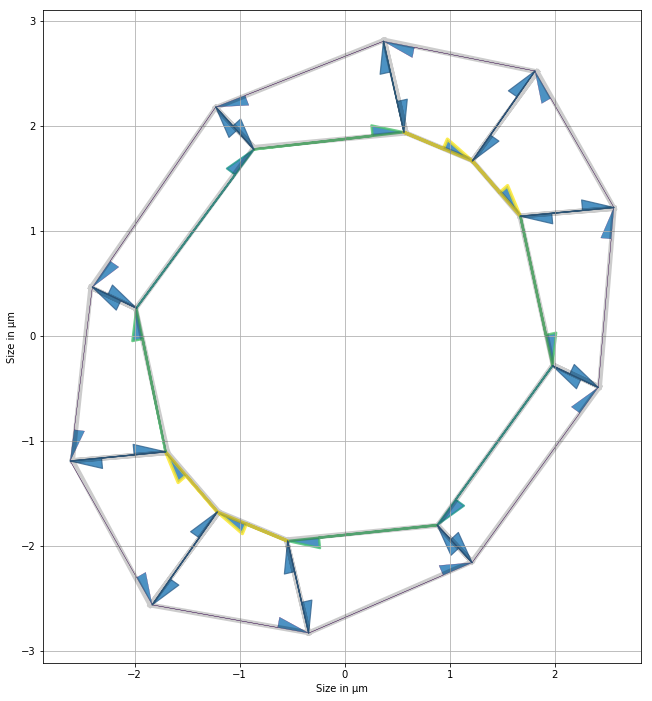

In [12]:
start = time.clock()
noisy_trf_nr_nl = noisy.copy()
res = adjust_tensions(noisy_trf_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, **trf_opt) 
noisy_trf_nr_nl.edge_df.line_tension = prepare_tensions(noisy_trf_nr_nl, res.x)
Solver.find_energy_min(noisy_trf_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_trf_nr_nl, organo)

In [14]:
noisy_trf_nr_nl.edge_df.line_tension

edge
0     9.596059e-02
1     1.275745e-01
2     1.811460e-01
3     1.818853e-01
4     1.287799e-01
5     9.644194e-02
6     1.303953e-01
7     1.813442e-01
8     1.820828e-01
9     1.312664e-01
10    1.236439e-03
11    2.592510e-03
12    3.833381e-03
13   -1.176054e-13
14    9.150319e-05
15    1.698569e-03
16    2.749030e-03
17    2.936986e-03
18    8.973673e-05
19   -9.747078e-14
20    5.670714e-02
21    5.537913e-02
22    5.679710e-02
23    5.687658e-02
24    5.732463e-02
25    5.601701e-02
26    5.719926e-02
27    5.915618e-02
28    5.549628e-02
29    5.777360e-02
30    5.537913e-02
31    5.679710e-02
32    5.687658e-02
33    5.732463e-02
34    5.601701e-02
35    5.719926e-02
36    5.915618e-02
37    5.549628e-02
38    5.777360e-02
39    5.670714e-02
Name: line_tension, dtype: float64

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.8838e+01                                    9.46e+02    
       1              4         5.2551e+01      6.29e+00       1.03e+01       3.47e+02    
       2              5         4.8781e+01      3.77e+00       9.65e+00       1.65e+02    
       3              6         4.7812e+01      9.69e-01       9.29e+00       3.88e+02    
       4              8         4.6997e+01      8.15e-01       2.43e+00       7.44e+01    
       5              9         4.6590e+01      4.06e-01       2.30e+00       6.04e+01    
`ftol` termination condition is satisfied.
Function evaluations 9, initial cost 5.8838e+01, final cost 4.6590e+01, first-order optimality 6.04e+01.
Solving time: 872.7258169999999
Tension error: [0.05385949 0.01342814 0.0081095  0.00402803 0.05173308 0.00062867
 0.00067976 0.00929955 0.00232789 0.00245173        inf        inf
        inf        inf        inf 

/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


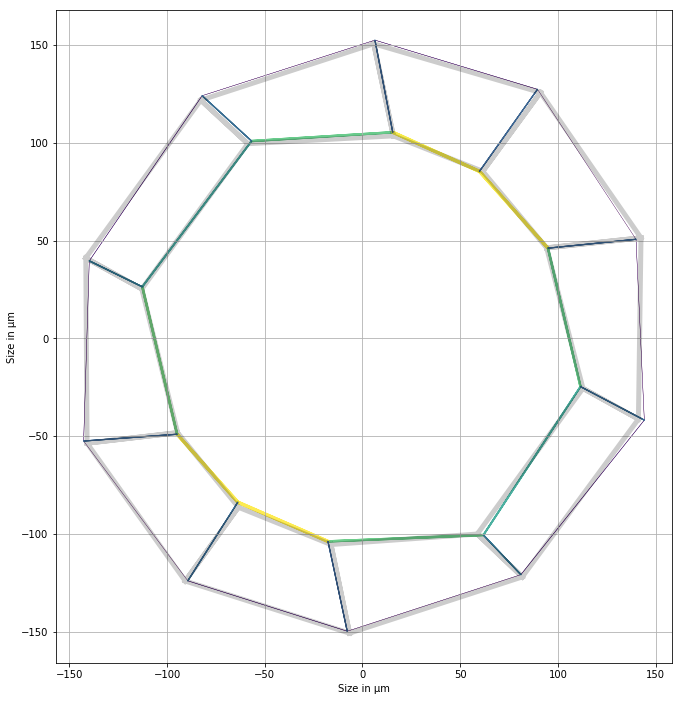

In [27]:
reg_weight = 1e-3

res = adjust_tensions(noisy, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **trf_opt)
noisy_trf_r_nl = noisy.copy()
noisy_trf_r_nl.edge_df.line_tension = prepare_tensions(noisy_trf_r_nl, res.x)
Solver.find_energy_min(noisy_trf_r_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_trf_r_nl, organo)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.1380e+01                                    9.04e+02    
       1              3         4.4767e+01      6.61e+00       2.99e+01       1.53e+03    
       2              4         4.1234e+01      3.53e+00       1.16e+01       7.15e+02    
`ftol` termination condition is satisfied.
Function evaluations 4, initial cost 5.1380e+01, final cost 4.1234e+01, first-order optimality 7.15e+02.
Solving time: 110.03109700000005
Tension error: [0.00174278 0.00506559 0.04358091 0.03946069 0.01010702 0.01231208
 0.02367344 0.01311309 0.00561374 0.02874056        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf 0.00336136 0.10070486 0.01404458 0.08611094
 0.00930212 0.11232887 0.02001703 0.01923692 0.00688194 0.02030775]


/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


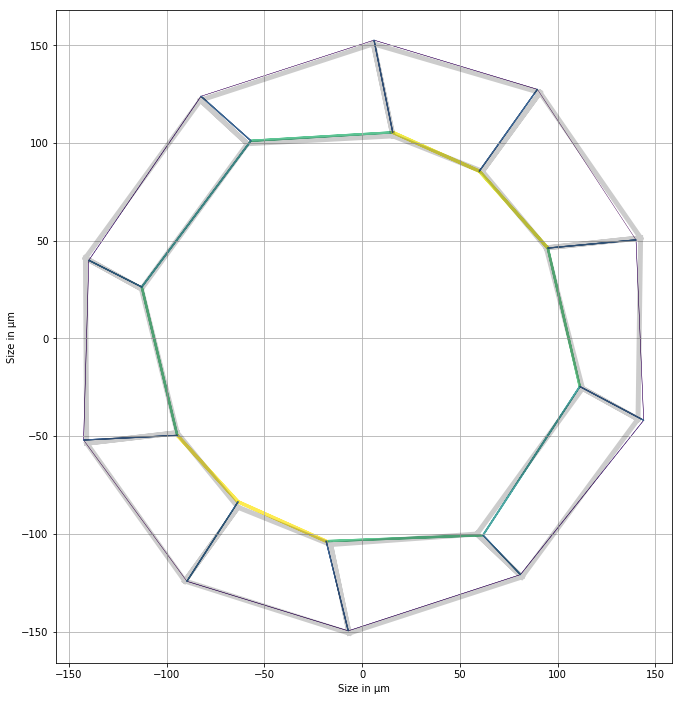

In [36]:
trf_opt = {'bounds': ([0]*(3*organo.Nf+1),[1000]*(3*organo.Nf)+[1e6]), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-1, 'verbose': 2}
start = time.clock()
res = adjust_tensions(noisy, np.concatenate((initial_guess[:3*organo.Nf], [organo.settings['lumen_volume']])), 
                      {'dic':{}, 'weight':0}, energy_opt, **trf_opt)
noisy_trf_nr_l = noisy.copy()
noisy_trf_nr_l.edge_df.line_tension = prepare_tensions(noisy_trf_nr_l, res.x)
Solver.find_energy_min(noisy_trf_nr_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_trf_nr_l, organo)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.0196e+01                                    9.08e+02    
       1              4         5.3673e+01      6.52e+00       2.93e+01       8.36e+03    
       2              5         5.1860e+01      1.81e+00       7.84e+01       1.20e+03    
       3              6         5.0534e+01      1.33e+00       8.04e+00       1.73e+02    
`ftol` termination condition is satisfied.
Function evaluations 6, initial cost 6.0196e+01, final cost 5.0534e+01, first-order optimality 1.73e+02.
Solving time: 154.24079100000017
Tension error: [0.03019931 0.01844342 0.0041788  0.01005615 0.02735372 0.00461438
 0.01370304 0.00763355 0.00026241 0.01957194        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf 0.04878182 0.18912103 0.01197708 0.04581259
 0.00903025 0.13338168 0.06076268 0.00981948 0.00027386 0.00396928]


/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


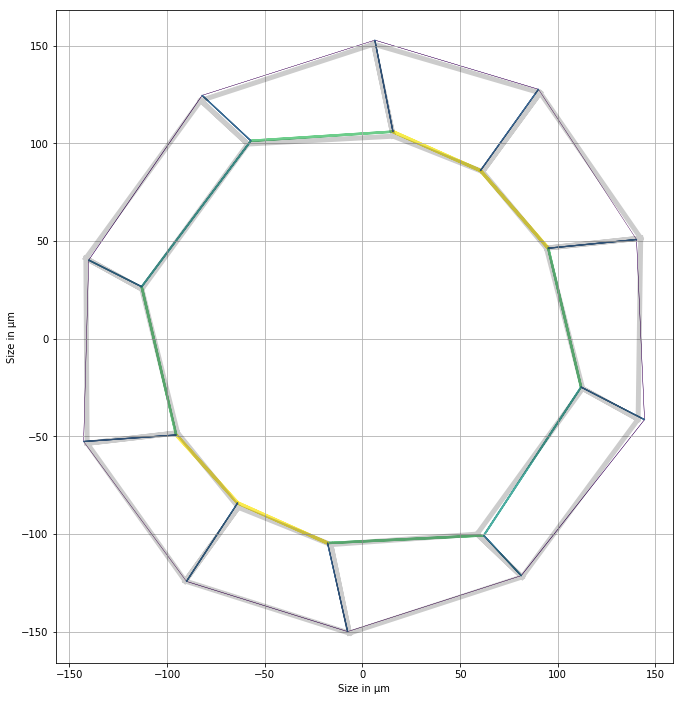

In [49]:
trf_opt = {'bounds': ([0]*(3*organo.Nf+1),[1000]*(3*organo.Nf)+[1e6]), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-1, 'verbose': 2}
start = time.clock()
res = adjust_tensions(noisy, np.concatenate((initial_guess[:3*organo.Nf], [organo.settings['lumen_volume']])),
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **trf_opt)
noisy_trf_r_l = noisy.copy()
noisy_trf_r_l.edge_df.line_tension = prepare_tensions(noisy_trf_r_l,res.x[:3*organo.Nf])
Solver.find_energy_min(noisy_trf_r_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_trf_r_l, organo)

## PSQP energy minimization
This minimization procedure uses Preconditionned Sequential Quadratic Programming (PSQP) procedure from pyOpt to find the set of linear tensions that minimizes the energy in the experimental organoïd under constraint that 
$$||X_e-X_t||<\epsilon $$
Where $X_e$ (resp. $X_t$) is the set of euclidian coordinates of the vertices of the experimental (resp. theoritical) organoïd, and $\epsilon$ is the maximum distance allowed between the two. 
Initial point is computed with lm procedure.

It can be implemented with or without a regulzarization module that regularize the linear tensions of the apical or basal edges. 
It can be implemented with or without the lumen volume as an optimization parameter.

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [87]:
start = time.clock()
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-15,'ftol': 1e-8, 'verbose': 2}
res = adjust_tensions(noisy, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, trf_opt, **psqp_opt)
noisy_psqp_nr_nl = noisy.copy()
noisy_psqp_nr_nl.edge_df.line_tension = prepare_tensions(noisy_psqp_nr_nl,res['x'])
Solver.find_energy_min(noisy_psqp_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res['x']),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_psqp_nr_nl, organo)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.1266e+01                                    5.64e+02    
       1              4         3.7719e+01      3.55e+00       8.76e+00       5.17e+02    
       2              5         3.4580e+01      3.14e+00       9.04e+00       3.18e+02    
       3              7         3.4409e+01      1.71e-01       2.21e+00       1.14e+02    
       4              8         3.4318e+01      9.12e-02       4.94e-01       5.06e+02    
       5              9         3.4150e+01      1.67e-01       1.15e+00       3.08e+02    
       6             10         3.4092e+01      5.85e-02       2.85e-01       1.72e+02    
       7             11         3.4017e+01      7.50e-02       2.78e-01       5.29e+02    
       8             23         3.4017e+01      5.80e-09       1.37e-07       8.70e+01    
       9             32         3.4017e+01      0.00e+00       0.00e+00       8.70e+01    

AttributeError: 'dict' object has no attribute 'x'

Solving time: 25392.366317999997
Tension error: [0.32839687 0.11529192 0.42825944 0.06946745 0.29033482 0.39552358
 0.44547072 0.0886001  0.11279058 0.03984246        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf 0.35298038 0.68585238 0.31899196 0.2634798
 0.26484766 0.57364033 0.07124582 2.05159386 1.40299209 2.62749666]


/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


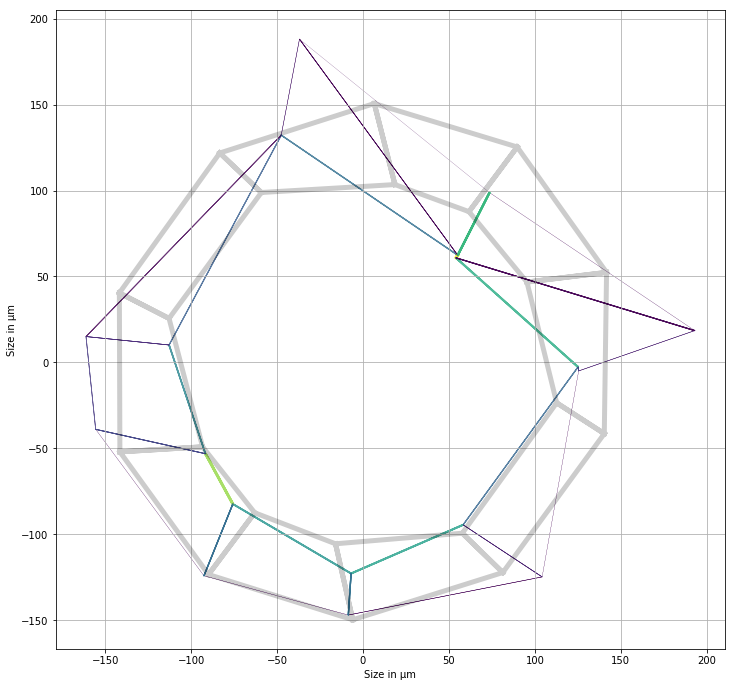

In [88]:
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res['x']),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_psqp_nr_nl, organo)

In [91]:
res

{'fun': array([4023362.84841349]),
 'message': {'text': 'Termination criterion not satisfied, but obtained point is acceptable',
  'value': -6},
 'x': array([ 5.10986026e+01,  9.05685192e+01,  8.28472752e+01,  1.34837533e+02,
         7.26491885e+01,  4.59912992e+01,  5.67677598e+01,  1.57742093e+02,
         1.61247380e+02,  9.82923612e+01, -3.76659177e+00, -3.97295177e+01,
         1.12212943e-02, -2.31159400e+01,  2.53116471e+01, -6.28753622e+01,
         8.88459813e+00, -7.58591658e+00, -4.22228825e+00,  1.24404093e+01,
         2.85231442e+01,  1.38488505e+01,  5.81463014e+01,  5.56991095e+01,
         3.24083777e+01,  1.87955945e+01,  4.09431008e+01, -4.63583522e+01,
         1.05933249e+02, -7.17463902e+01])}

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
res = adjust_tensions(noisy, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, trf_opt, **psqp_opt)
noisy_psqp_r_nl = noisy.copy()
noisy_psqp_r_nl.edge_df.line_tension = prepare_tensions(noisy_psqp_r_nl,res.x)
Solver.find_energy_min(noisy_psqp_r_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_psqp_r_nl)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
res = adjust_tensions(noisy, np.concatenate((initial_guess[:3*organo.Nf], [organo.settings['lumen_volume']])), 
                      {'dic':{}, 'weight':0}, energy_opt, trf_opt, **psqp_opt)
noisy_psqp_nr_l = noisy.copy()
noisy_psqp_nr_l.edge_df.line_tension = prepare_tensions(noisy_psqp_nr_l,res.x[:3*organo.Nf])
Solver.find_energy_min(noisy_psqp_nr_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_psqp_nr_l)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
res = adjust_tensions(noisy, np.concatenate((initial_guess[:3*organo.Nf], [organo.settings['lumen_volume']])),
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, trf_opt, **psqp_opt) 
noisy_psqp_r_l = noisy.copy()
noisy_psqp_r_l.edge_df.line_tension = prepare_tensions(noisy_psqp_r_l,res.x[:3*organo.Nf])
Solver.find_energy_min(noisy_psqp_r_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(noisy_psqp_r_l)

# Stability to the initial guess

We will now test the behavior of the solution of our optimization processes wrt the distance from the optimum to the initial guess. We will work directly on the theoritical mesh and the initial guess will be defined as proposed in the doc.

In [70]:
initial_guess = set_init_point(organo.settings['R_in'], organo.settings['R_out'], organo.Nf, alpha)

## LM distance minimization
This minimization procedure uses Levenberg-Marquardt (lm) procedure from scipy.least_squares to find the set of linear tensions that minimize the euclidian distance from the theoritical organoid to the experimental organoid. Extensive description can be found above.

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

`xtol` termination condition is satisfied.
Function evaluations 182, initial cost 9.3707e+02, final cost 9.0846e+02, first-order optimality 2.64e+06.
Solving time: 841.0718869999992
Tension error: [5.68658337e-07 2.56778011e-01 4.74930134e-01 4.74928044e-01
 2.56772595e-01 9.57745319e-07 2.56776517e-01 4.74930137e-01
 4.74929947e-01 2.56777456e-01            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
 9.96530049e-07 1.75267967e-07 2.52101690e-06 2.57722500e-06
 1.46470456e-08 1.23351706e-07 1.92004021e-06 6.29918227e-07
 2.84135897e-06 3.07365774e-06]


/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


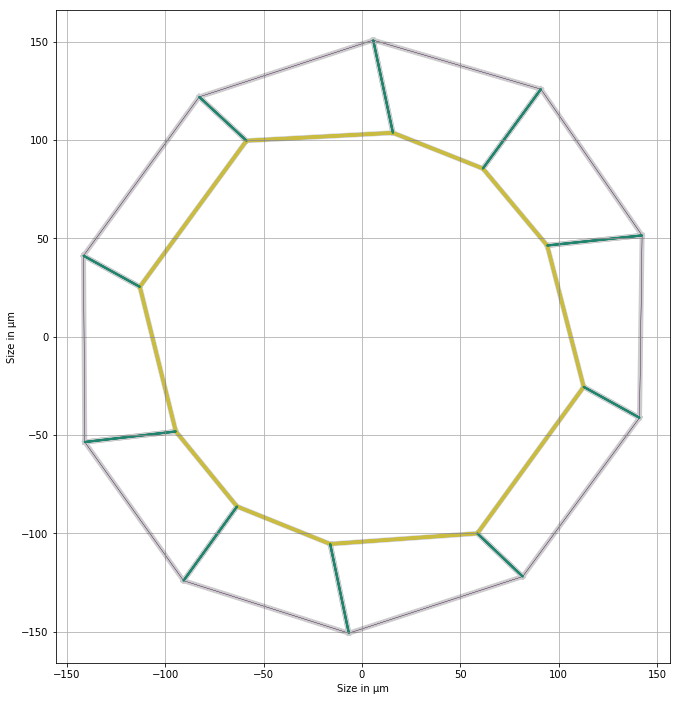

In [71]:
start = time.clock()
copy_lm_nr_nl = organo.copy()
res = adjust_tensions(copy_lm_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, **lm_opt)
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl,res.x)
Solver.find_energy_min(noisy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

`ftol` termination condition is satisfied.
Function evaluations 168, initial cost 1.2269e+03, final cost 2.1899e+02, first-order optimality 6.80e+05.
Solving time: 601.494909
Tension error: [0.05011477 0.23736733 0.24703025 0.1112441  0.14238477 0.24989645
 0.33254426 0.02624267 0.16565155 0.00225887        inf        inf
        inf        inf        inf        inf        inf        inf
        inf        inf 0.03843568 0.15848428 0.08664972 0.38731158
 0.42177542 0.25652869 0.25585028 0.55134629 0.12295339 0.46510504]


/home/fquinton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


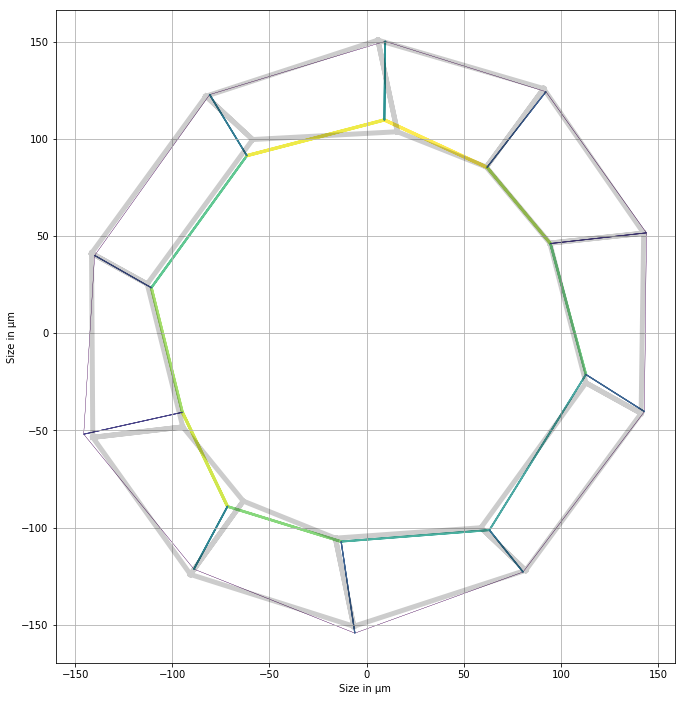

In [66]:
start = time.clock()
copy_lm_r_nl = organo.copy()
res = adjust_tensions(copy_lm_r_nl, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **lm_opt)
copy_lm_r_nl.edge_df.line_tension = prepare_tensions(copy_lm_r_nl,res.x)
Solver.find_energy_min(copy_lm_r_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_r_nl, organo)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [67]:
start = time.clock()
copy_lm_nr_l = organo.copy()
res = adjust_tensions(copy_lm_nr_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])), 
                      {'dic':{}, 'weight':0}, energy_opt, **lm_opt)
copy_lm_nr_l.edge_df.line_tension = prepare_tensions(copy_lm_nr_l,res.x)
Solver.find_energy_min(copy_lm_nr_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_l, organo)

KeyboardInterrupt: 

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_lm_r_l = organo.copy()
res = adjust_tensions(copy_lm_r_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])),
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **lm_opt)
copy_lm_r_l.edge_df.line_tension = prepare_tensions(copy_lm_r_l,res.x)
Solver.find_energy_min(copy_lm_r_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_r_l, organo)

## TRF distance minimization
This minimization procedure uses Trust Region Function (trf) procedure from scipy.least_squares to find the set of linear tensions that minimize the euclidian distance from the theoritical organoid to the experimental organoid. 
It can be implemented with or without a regulzarization module that regularize the linear tensions of the apical or basal edges. 
It can be implemented with or without the lumen volume as an optimization parameter.

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_trf_nr_nl = organo.copy()
res = adjust_tensions(copy_trf_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, **trf_opt) 
copy_trf_nr_nl.edge_df.line_tension = prepare_tensions(copy_trf_nr_nl, res.x)
Solver.find_energy_min(copy_trf_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_trf_nr_nl, organo)

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_trf_r_nl = organo.copy()
res = adjust_tensions(copy_trf_r_nl, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **trf_opt)
copy_trf_r_nl.edge_df.line_tension = prepare_tensions(copy_trf_r_nl, res.x)
Solver.find_energy_min(copy_trf_r_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_trf_r_nl, organo)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
trf_opt = {'bounds': ([0]*(3*organo.Nf+1),[1000]*(3*organo.Nf)+[1e6]), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-1, 'verbose': 0}
start = time.clock()
copy_trf_nr_l = organo.copy()
res = adjust_tensions(copy_trf_nr_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])), 
                      {'dic':{}, 'weight':0}, energy_opt, **trf_opt)
copy_trf_nr_l.edge_df.line_tension = prepare_tensions(copy_trf_nr_l, res.x)
Solver.find_energy_min(copy_trf_nr_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_trf_nr_l, organo)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
trf_opt = {'bounds': ([0]*(3*organo.Nf+1),[100]*(3*organo.Nf)+[1e6]), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-1, 'verbose': 0}
start = time.clock()
copy_trf_r_l = copy.copy()
res = adjust_tensions(copy_trf_r_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])),
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, **trf_opt)
copy_trf_r_l.edge_df.line_tension = prepare_tensions(copy_trf_r_l,res.x[:3*organo.Nf])
Solver.find_energy_min(copy_trf_r_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_trf_r_l)

## PSQP energy minimization
This minimization procedure uses Preconditionned Sequential Quadratic Programming (PSQP) procedure from pyOpt to find the set of linear tensions that minimizes the energy in the experimental organoïd under constraint that 
$$||X_e-X_t||<\epsilon $$
Where $X_e$ (resp. $X_t$) is the set of euclidian coordinates of the vertices of the experimental (resp. theoritical) organoïd, and $\epsilon$ is the maximum distance allowed between the two. 
Initial point is computed with lm procedure.

It can be implemented with or without a regulzarization module that regularize the linear tensions of the apical or basal edges. 
It can be implemented with or without the lumen volume as an optimization parameter.

### Without regularization module nor lumen volume
Without the regularization module nor lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_psqp_nr_nl = organo.copy()
res = adjust_tensions(copy_psqp_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                      energy_opt, lm_opt, **psqp_opt)
copy_psqp_nr_nl.edge_df.line_tension = prepare_tensions(copy_psqp_nr_nl,res.x)
Solver.find_energy_min(copy_psqp_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_psqp_nr_nl)

### With regularization module, without lumen volume
With the regularization module but without lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_psqp_r_nl = organo.copy()
res = adjust_tensions(copy_psqp_r_nl, initial_guess, 
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, lm_opt, **psqp_opt)
copy_psqp_r_nl.edge_df.line_tension = prepare_tensions(copy_psqp_r_nl,res.x)
Solver.find_energy_min(copy_psqp_r_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_psqp_r_nl)

### Without regularization module, with lumen volume
Without the regularization module but with lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_psqp_nr_l = organo.copy()
res = adjust_tensions(copy_psqp_nr_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])),
                      {'dic':{}, 'weight':0},
                      energy_opt, lm_opt, **psqp_opt)
copy_psqp_nr_l.edge_df.line_tension = prepare_tensions(copy_psqp_nr_l,res.x[:3*organo.Nf])
Solver.find_energy_min(copy_psqp_nr_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_psqp_nr_l)

### With regularization module and with lumen volume
With the regularization module and lumen volume as an optimization variable, we test the robustness of the procedure to extraction (ie image processing) errors and to initial point deviation.

In [ ]:
start = time.clock()
copy_psqp_r_l = organo.copy()
res = adjust_tensions(copy_psqp_r_l, np.concatenate((initial_guess, [organo.settings['lumen_volume']])),
                      {'dic':{'apical' : True, 'basal': True}, 'weight':reg_weight},
                      energy_opt, lm_opt, **psqp_opt) 
copy_psqp_r_l.edge_df.line_tension = prepare_tensions(copy_psqp_r_l,res.x[:3*organo.Nf])
Solver.find_energy_min(copy_psqp_r_l, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-res.x[:3*organo.Nf]),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_psqp_r_l)